
=== Dataset Information ===
Final shape: (58976, 105)
Missing values:
age             0
LOSdays         0
NumCallouts     0
NumDiagnosis    0
NumProcs        0
dtype: int64


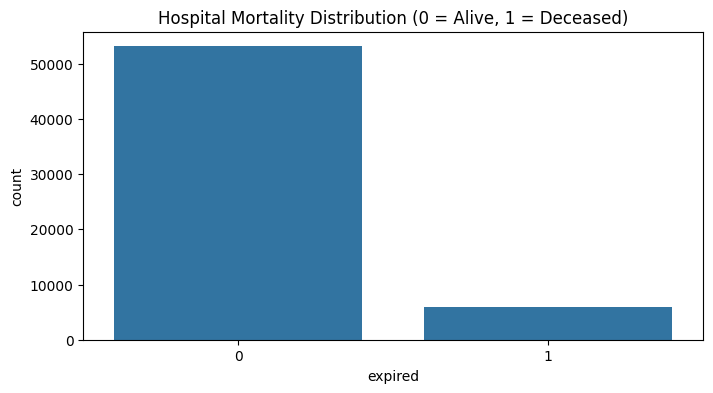

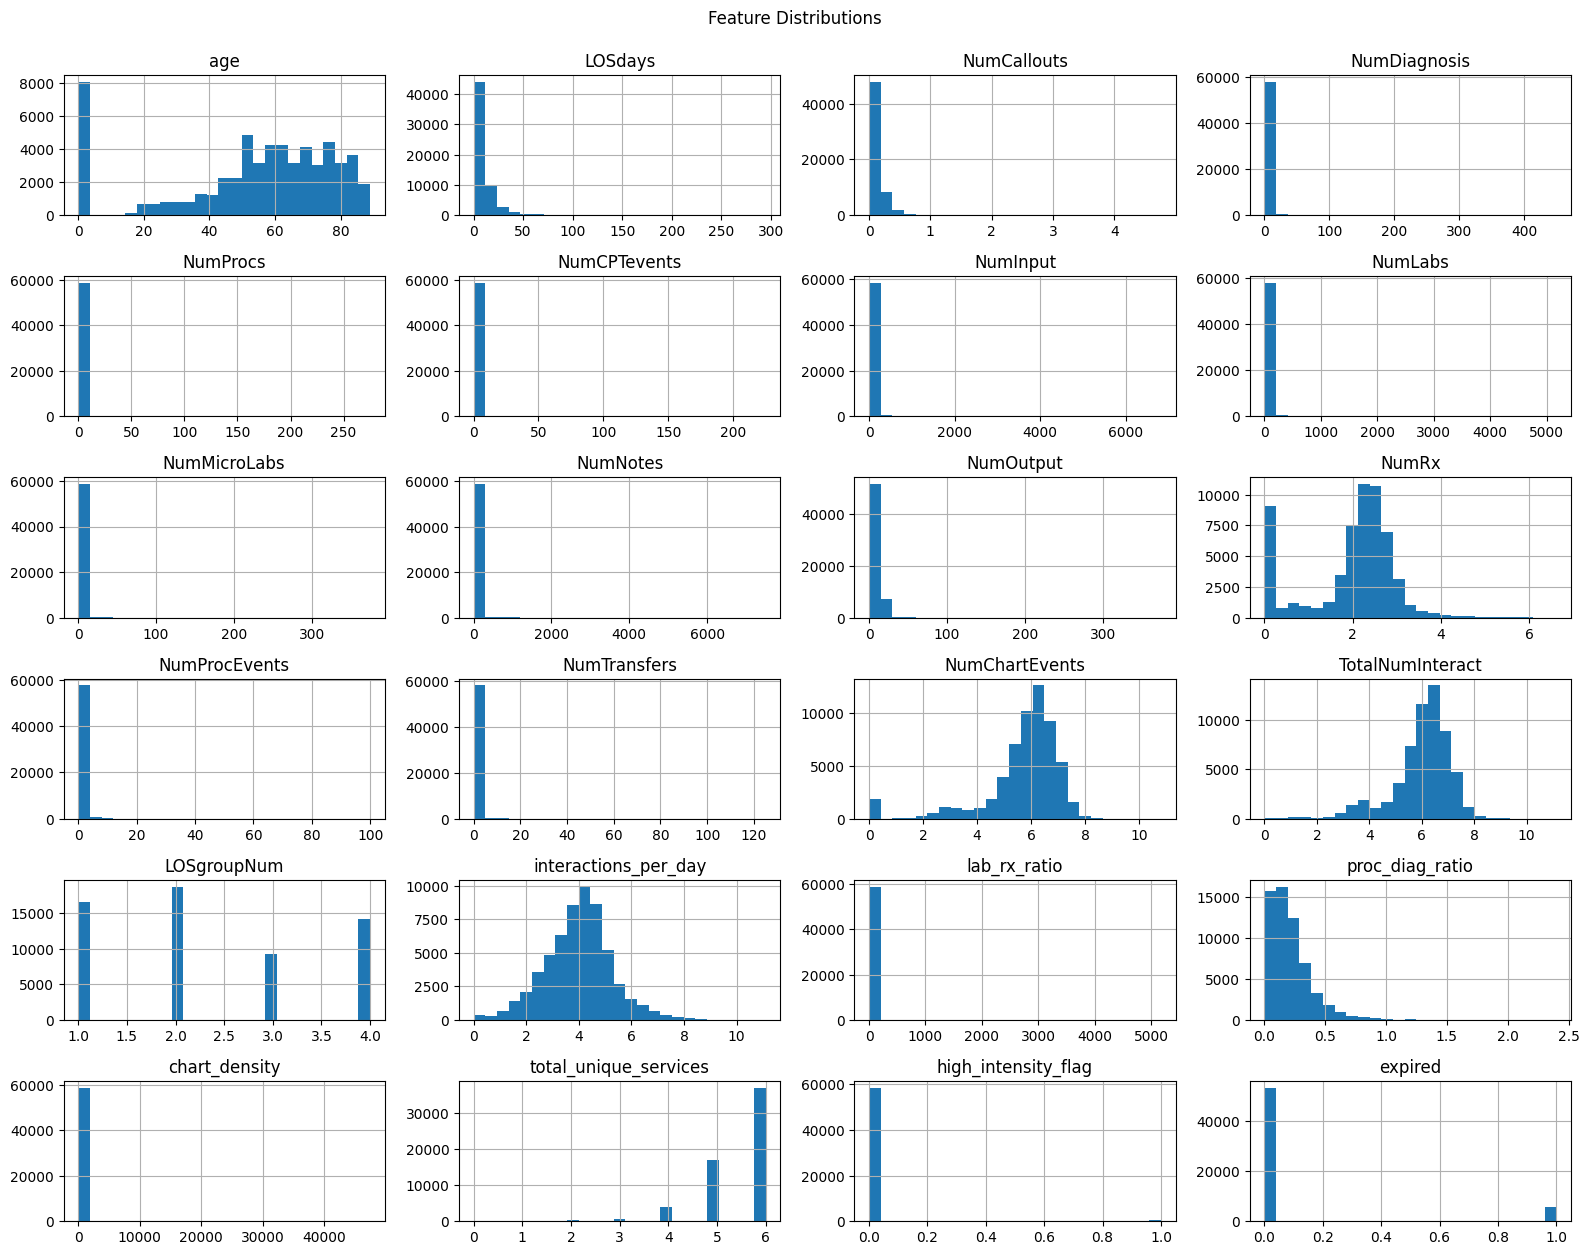

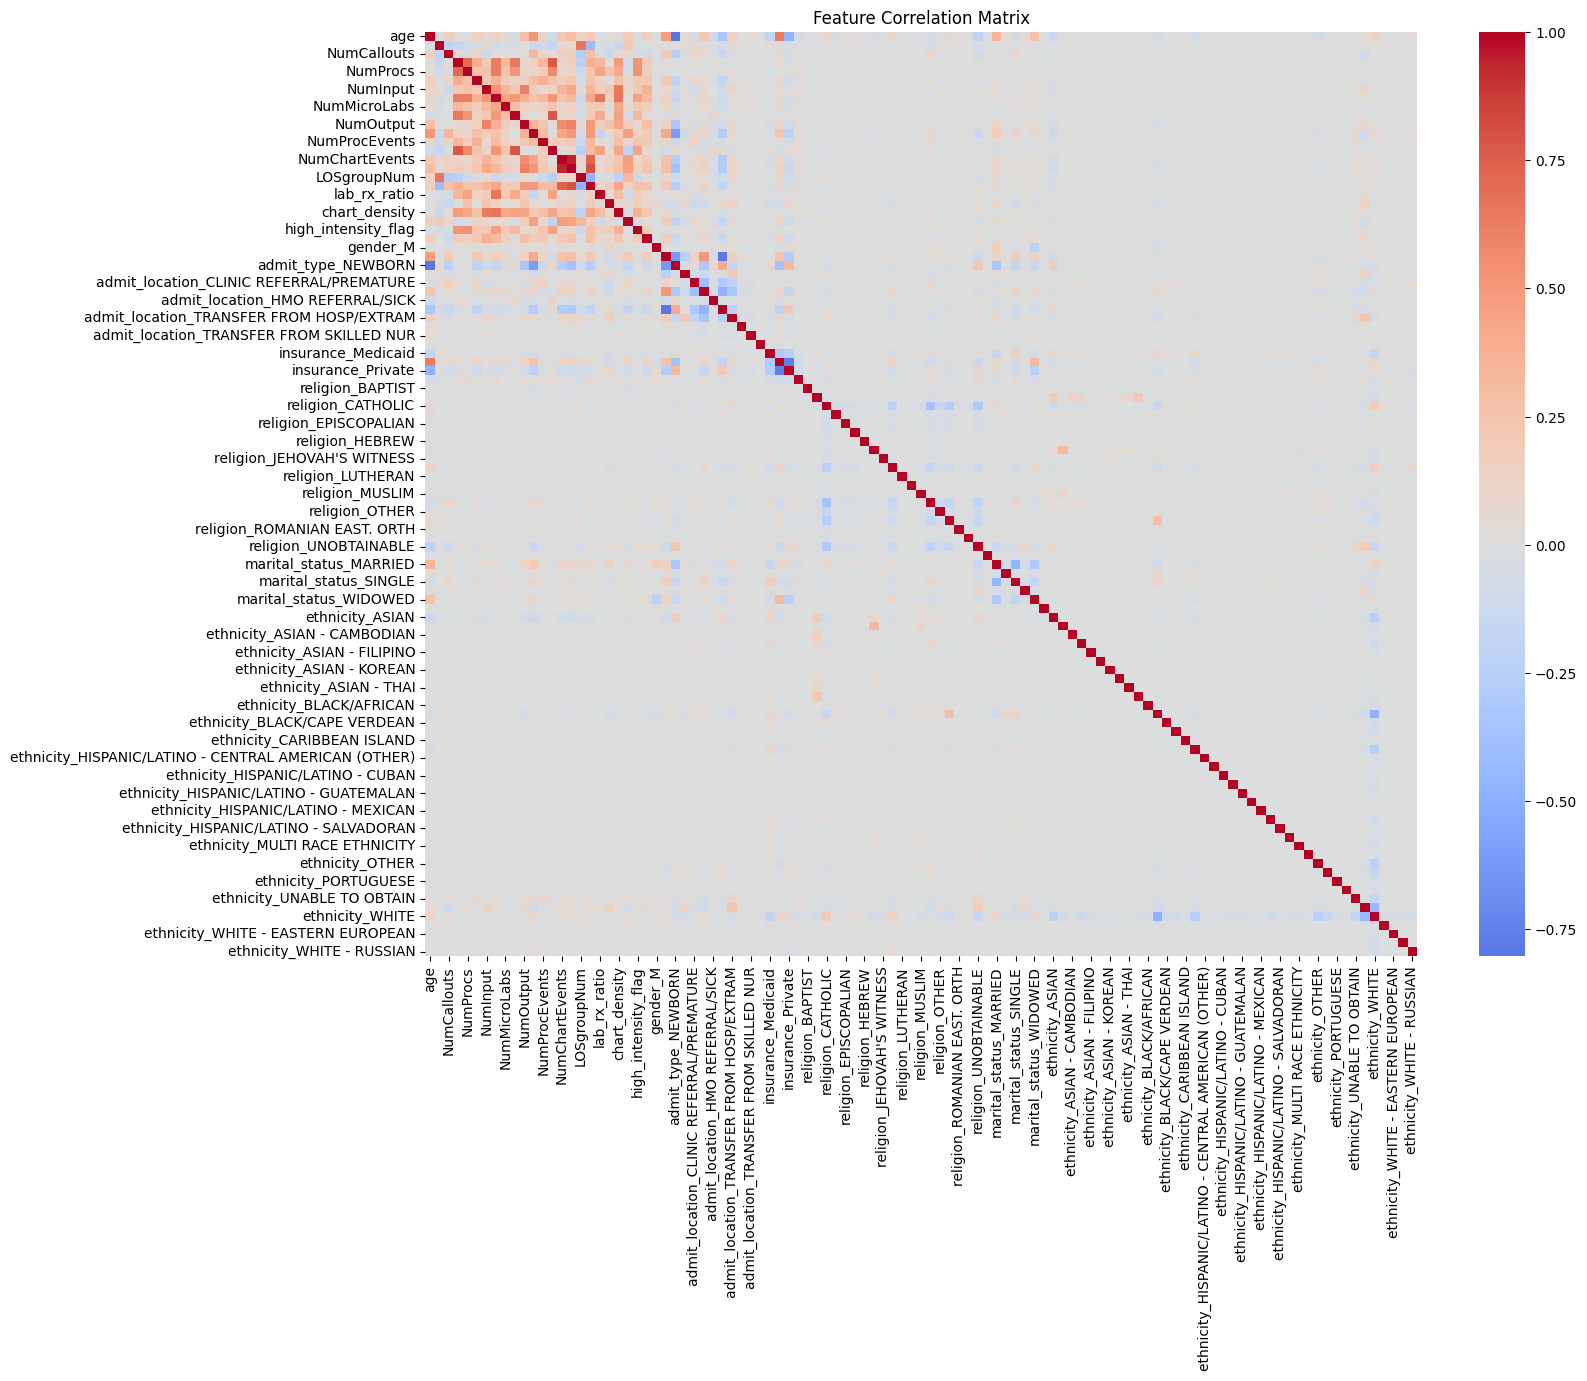

C:\Users\gf\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10625
           1       0.80      0.40      0.53      1171

    accuracy                           0.93     11796
   macro avg       0.87      0.69      0.75     11796
weighted avg       0.92      0.93      0.92     11796

AUC: 0.8962

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     10625
           1       0.86      0.47      0.61      1171

    accuracy                           0.94     11796
   macro avg       0.90      0.73      0.79     11796
weighted avg       0.94      0.94      0.93     11796

AUC: 0.9311


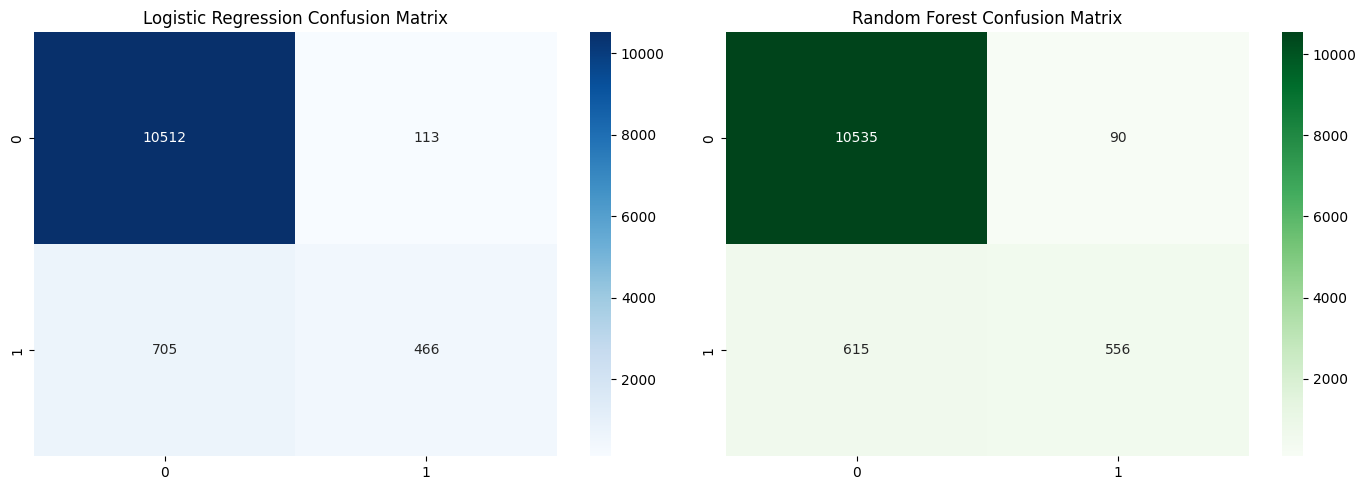

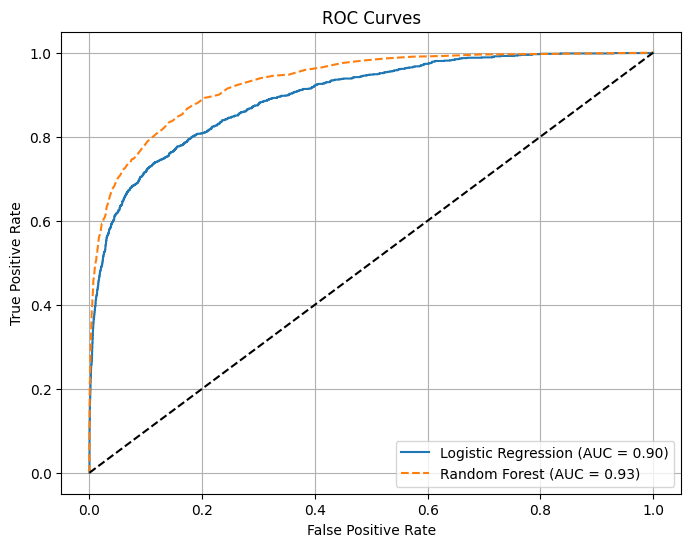

C:\Users\gf\AppData\Local\Temp\ipykernel_17072\111561370.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_idx], y=X.columns[sorted_idx], palette='viridis')


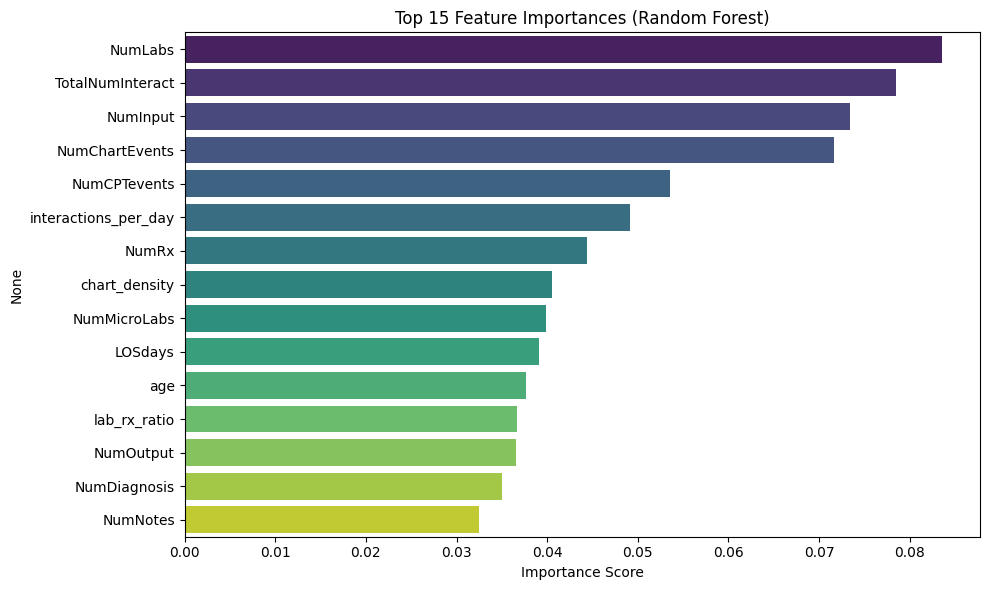

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Load dataset
df = pd.read_csv('mimic3c.csv')

# --- Feature Engineering ---
# Total interactions (if not already present)
if 'TotalNumInteract' not in df.columns:
    df['TotalNumInteract'] = (
        df['NumLabs'] + 
        df['NumMicroLabs'] + 
        df['NumRx'] + 
        df['NumNotes'] + 
        df['NumProcs'] +
        df['NumChartEvents'] +
        df['NumCareVueEvents']
    )

# Derived features
df['interactions_per_day'] = df['TotalNumInteract'] / (df['LOSdays'] + 1)
df['lab_rx_ratio'] = df['NumLabs'] / (df['NumRx'] + 1)
df['proc_diag_ratio'] = df['NumProcs'] / (df['NumDiagnosis'] + 1)
df['chart_density'] = df['NumChartEvents'] / (df['LOSdays'] + 1)
df['total_unique_services'] = (
    (df['NumLabs'] > 0).astype(int) +
    (df['NumMicroLabs'] > 0).astype(int) +
    (df['NumRx'] > 0).astype(int) +
    (df['NumNotes'] > 0).astype(int) +
    (df['NumProcs'] > 0).astype(int) +
    (df['NumChartEvents'] > 0).astype(int)
)
df['high_intensity_flag'] = ((df['NumNotes'] > 10) & (df['NumProcs'] > 5)).astype(int)
df['expired'] = df['ExpiredHospital'].astype(int)

# --- Data Cleaning ---
# Handle missing values (example - adjust based on actual null analysis)
df.fillna(df.mean(numeric_only=True), inplace=True)

# --- Categorical Encoding ---
categorical_cols = ['gender', 'admit_type', 'admit_location', 'insurance', 'religion', 'marital_status', 'ethnicity']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# --- Column Selection ---
drop_cols = ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']
df.drop(columns=drop_cols, inplace=True, errors='ignore')

# --- Feature Transformation ---
skewed_cols = ['TotalNumInteract', 'interactions_per_day', 'NumChartEvents', 'NumRx']
log_transformer = FunctionTransformer(np.log1p)
df[skewed_cols] = log_transformer.fit_transform(df[skewed_cols])

# --- EDA ---
print("\n=== Dataset Information ===")
print(f"Final shape: {df.shape}")
print(f"Missing values:\n{df.isnull().sum().sort_values(ascending=False).head(5)}")

# Target distribution
plt.figure(figsize=(8, 4))
sns.countplot(x='expired', data=df)
plt.title('Hospital Mortality Distribution (0 = Alive, 1 = Deceased)')
plt.show()

# Feature distributions
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numerical_cols].hist(bins=25, figsize=(16, 14), layout=(7, 4))
plt.tight_layout()
plt.suptitle('Feature Distributions', y=1.02)
plt.show()

# Correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Matrix')
plt.show()

# --- Modeling ---
X = df.drop(columns=['expired'])
y = df['expired']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
y_proba_log = log_reg.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression ===")
print(classification_report(y_test, y_pred_log))
print(f"AUC: {roc_auc_score(y_test, y_proba_log):.4f}")

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print(f"AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")

# --- Evaluation Visualizations ---
# Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_log), 
            annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('Logistic Regression Confusion Matrix')

sns.heatmap(confusion_matrix(y_test, y_pred_rf), 
            annot=True, fmt='d', ax=ax[1], cmap='Greens')
ax[1].set_title('Random Forest Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curve
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_proba_log):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance
importances = rf.feature_importances_
sorted_idx = importances.argsort()[::-1][:15]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_idx], y=X.columns[sorted_idx], palette='viridis')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()